In [29]:
from datetime import datetime
from pathlib import Path
import os

import click
import torch
import wandb
from lightning import Trainer
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.loggers import WandbLogger
import logging
import lightning as L
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from transformers import EsmForMaskedLM, AutoTokenizer


from egfr_binder_rd2.datamodule import SequenceDataModule
from egfr_binder_rd2.bt import BTRegressionModule
from egfr_binder_rd2.binding_dataset import get_dataset


%load_ext autoreload
%autoreload 2

torch.set_float32_matmul_precision('medium')

seed = 42
debug = True


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def setup_logging(debug: bool):
    level = logging.DEBUG if debug else logging.INFO
    logging.basicConfig(
        level=level,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )
    logger = logging.getLogger(__name__)
    logger.info("Logging setup complete.")
    return logger

In [3]:
yvar = 'Average_i_pAE'
# yvar = 'Average_i_pTM'
yvar = 'Average_pLDDT'
yvar = 'encoded_expression'

In [ ]:
fp = '/home/naka/code/BindCraft/outputs/EGFR_single_domain/mpnn_design_stats.csv'
df = pd.read_csv(fp)


In [ ]:
fp = 'https://raw.githubusercontent.com/adaptyvbio/egfr_competition_1/refs/heads/main/results/replicate_summary.csv'
seqs = pd.read_csv('https://raw.githubusercontent.com/adaptyvbio/egfr_competition_1/refs/heads/main/results/result_summary.csv')
df = pd.read_csv(fp).merge(seqs[['name', 'sequence']])

In [ ]:
expression_map = {'low': 1, 'medium': 2, 'high': 3, 'none': 0}
df['encoded_expression'] = df['nc_adjusted_expression'].map(expression_map)

In [ ]:
df = df.groupby(['name', 'sequence']).agg({'encoded_expression': 'mean'}).reset_index()

In [ ]:
df.dropna(subset=[yvar])

In [3]:
df = get_dataset()
yvar = 'pae_interaction'
xvar = 'binder_sequence'

In [4]:

# Create and setup the DataModule
data_module = SequenceDataModule(
    df, 
    tokenizer_name="facebook/esm2_t33_650M_UR50D",
    xvar=xvar,
    yvar=yvar,  # You can change this to any other column name in your DataFrame
    batch_size=36,
    max_length=512,
    transform_type='rank',
    make_negative=True,
)
data_module.setup()



Map: 100%|██████████| 883/883 [00:00<00:00, 1830.84 examples/s]
/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 177/177 [00:00<00:00, 2221.88 examples/s]


In [5]:

# 3. Create the model
model = BTRegressionModule(
    label=yvar,
    # model_name="facebook/esm2_t33_650M_UR50D",
    # model_name="facebook/esm2_t30_150M_UR50D",
    # model_name='facebook/esm2_t12_35M_UR50D',
    model_name='facebook/esm2_t6_8M_UR50D',
    lr=1e-3,
    peft_r=8,
    peft_alpha=16,
    max_length=512,
)

# 4. Set up callbacks
early_stop_callback = EarlyStopping(
    monitor='val_spearman',
    min_delta=0.00,
    patience=30,
    verbose=False,
    mode='max'
)

# 5. Set up wandb logger
wandb_logger = WandbLogger(project="bt_regression")

# 6. Create the trainer
trainer = L.Trainer(
    max_epochs=40,
    callbacks=[early_stop_callback],
    logger=wandb_logger,
    accelerator='gpu',
    devices=1,  # Use 1 GPU
    log_every_n_steps=10,
    enable_checkpointing=False,  # Disable checkpoint saving
    val_check_interval=0.25,  # Check validation 4 times per epoch
)


/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/naka/code/

In [6]:

# 7. Train the model
trainer.fit(model, data_module)


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: anaka (anaka_personal). Use `wandb login --relogin` to force relogin


Map: 100%|██████████| 883/883 [00:00<00:00, 2613.15 examples/s]
/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 177/177 [00:00<00:00, 2376.85 examples/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                               | Params | Mode 
-----------------------------------------------------------------------------
0 | esm_model     | PeftModelForSequenceClassification | 8.0 M  | train
1 | bt_loss       | BradleyTerryLoss                   | 0      | train
2 | train_metrics | MetricCollection                   | 0      | train
3 | val_mae       | MeanAbsoluteError                  | 0      | train
4 | val_spearman  | SpearmanCorrCoef                   | 0      | train
---------

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 29:   6%|▌         | 1/18 [00:00<00:01,  8.63it/s, v_num=pfmf] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [8]:
train_preds = trainer.predict(model, data_module.train_dataloader(shuffle=False))
val_preds = trainer.predict(model, data_module.val_dataloader())
test_preds = trainer.predict(model, data_module.test_dataloader())



/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/naka/code/egfr_binder_rd2/.venv/lib/python3.11 ...
Map: 100%|██████████| 177/177 [00:00<00:00, 2231.48 examples/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/naka/code/egfr_binder_rd2/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 18/18 [00:00<00:00, 18.42it/s]


Map: 100%|██████████| 177/177 [00:00<00:00, 2417.18 examples/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 18.06it/s] 


Map: 100%|██████████| 177/177 [00:00<00:00, 2415.67 examples/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 18.11it/s] 


In [ ]:
train_preds = torch.cat(train_preds)
val_preds = torch.cat(val_preds)
test_preds = torch.cat(test_preds)

# Convert predictions to numpy arrays
train_preds = train_preds.cpu().numpy()
val_preds = val_preds.cpu().numpy() 
test_preds = test_preds.cpu().numpy()


In [13]:


# Get actual values
train_actual = data_module.train_dataset[yvar].numpy()
val_actual = data_module.val_dataset[yvar].numpy()
test_actual = data_module.test_dataset[yvar].numpy()

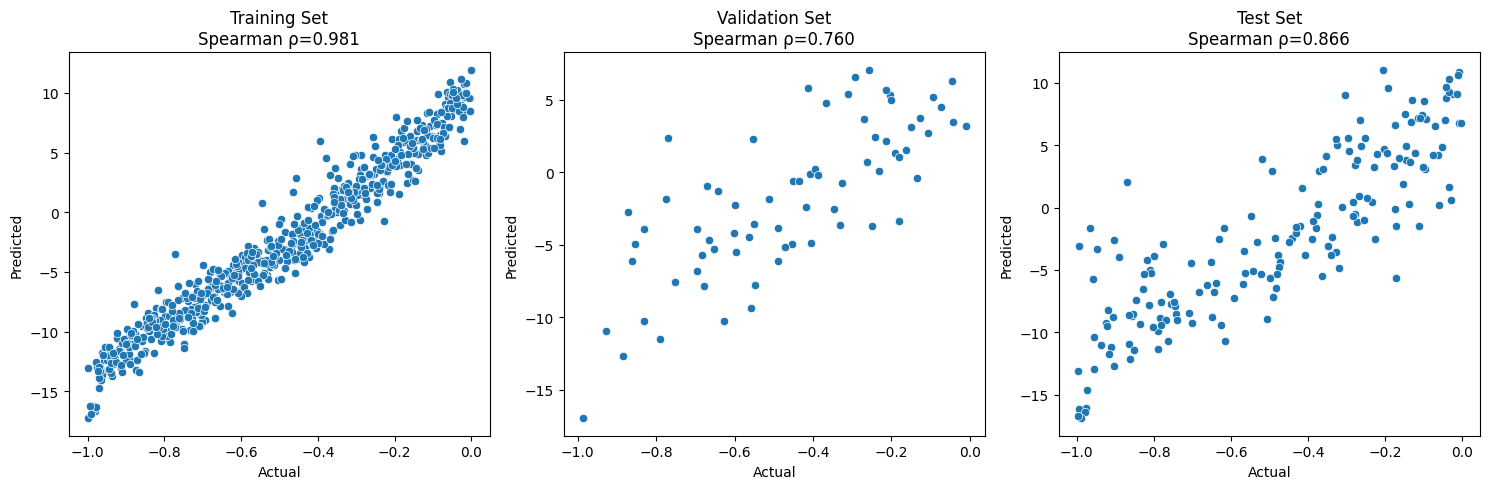

In [14]:

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot training data
sns.scatterplot(x=train_actual, y=train_preds, ax=ax1)
ax1.set_title('Training Set')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')

# Plot validation data
sns.scatterplot(x=val_actual, y=val_preds, ax=ax2)
ax2.set_title('Validation Set')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')

# Plot test data
sns.scatterplot(x=test_actual, y=test_preds, ax=ax3)
ax3.set_title('Test Set')
ax3.set_xlabel('Actual')
ax3.set_ylabel('Predicted')

# Add correlation coefficients to titles
train_corr = spearmanr(train_actual, train_preds)[0]
val_corr = spearmanr(val_actual, val_preds)[0]
test_corr = spearmanr(test_actual, test_preds)[0]

ax1.set_title(f'Training Set\nSpearman ρ={train_corr:.3f}')
ax2.set_title(f'Validation Set\nSpearman ρ={val_corr:.3f}')
ax3.set_title(f'Test Set\nSpearman ρ={test_corr:.3f}')

plt.tight_layout()
plt.show()

In [15]:
from egfr_binder_rd2.esm_regression_expert import EsmRegressionExpert
import evo_prot_grad
from tqdm import tqdm

In [30]:
i_pae_expert = EsmRegressionExpert(
    temperature=1.0,
    model=model,
    tokenizer=model.tokenizer,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

In [48]:
esm_expert = evo_prot_grad.get_expert(
    expert_name='esm',
    scoring_strategy="mutant_marginal",
    model = EsmForMaskedLM.from_pretrained("facebook/esm2_t33_650M_UR50D"),
    tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D"),
    device="cuda" if torch.cuda.is_available() else "cpu",
)

In [70]:
experts = [esm_expert, i_pae_expert]

In [83]:
sequence = df.iloc[0]['binder_sequence'] + 'ELR'

In [97]:
sequence = 'AERMRRRFEHIVEIHEEWAKEVLENLKKQGSKEEDLKFMEEYLEQDVEELRKRAEEMVEEYEKSS'

In [98]:
serial_chains = 4
n_steps = 250
max_mutations = 5
verbose=False
n_parallel_chains = 4
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

results = []
total_chains = 0

for _ in tqdm(range(serial_chains)):
    variants, scores = evo_prot_grad.DirectedEvolution(
        wt_protein=sequence,
        output="all",
        experts=experts,
        parallel_chains=n_parallel_chains,
        n_steps=n_steps,
        max_mutations=max_mutations,
        verbose=verbose,
        # preserved_regions=[(103, 104), (208, 209), (212, 213)],
    )()
    for chain in range(scores.shape[1]):
        for step in range(scores.shape[0]):
            seq = "".join(variants[step][chain].split(" "))
            score = scores[step, chain]
            results.append(
                {
                    "run": timestamp,
                    "chain": total_chains,
                    "step": step,
                    "score": score,
                    "sequence": seq,
                }
            )
        total_chains += 1

100%|██████████| 4/4 [01:23<00:00, 20.98s/it]


In [56]:
score

20.482964

In [99]:
sampled = pd.DataFrame(results)
sampled = sampled.drop_duplicates(subset=['sequence'])

In [100]:
sampled

,run,chain,step,score,sequence
0,20241030-234716,0,0,2.686405,AERMRRRFEHIVEIHEEWAKEVLENLKKQGSKEEDLKFMEEFLEQD...
1,20241030-234716,0,1,9.457047,AETMRRRFEHIVEIHEEWAKEVLENLKKQGSKEEDLKFMEEFLEQD...
2,20241030-234716,0,2,13.343776,AETMRRRFEHIVEIHEEWAKEVLENLKKQGSKEEDLKFMEEFLEQD...
3,20241030-234716,0,3,13.343776,MEVMRRRFEHIVEIHEEWAKEVLENLKKQGSKEEDLKFMEEYLEQD...
4,20241030-234716,0,4,9.660851,MEVMRRRFEHIVEIHEEWAKEVLENLKKQGSKEEDLKFMEEYLEQD...
...,...,...,...,...,...
3995,20241030-234716,15,245,16.913095,MERMRRRFEHIVEIVEEWAKEVLENEKKQGSKEEDLKFMEEYLEAD...
3996,20241030-234716,15,246,16.913095,AERMRRRFEHIVEIREEWAKEVLENLKKQGSKEEDLKFMEEYLEHD...
3997,20241030-234716,15,247,13.506359,AERMRRRFEHIVEEREEWAKEVLENLKKQGSKEEDLKFMEEYLEHD...
3998,20241030-234716,15,248,20.587156,KERMRRRFEHIVEEREEWAKEVLENLKKQGSKEEDLKHMEEYLEHD...


In [103]:
sequences = sampled.sort_values('score', ascending=False).head(300).sample(16)['sequence'].to_list()

In [105]:
import modal

get_msa = modal.Function.lookup("simplefold", 'get_msa_for_binder')
a3m_from_template = modal.Function.lookup("simplefold", 'a3m_from_template')
fold_binder = modal.Function.lookup("simplefold", 'fold_binder')
update_metrics = modal.Function.lookup("simplefold", 'update_metrics_for_all_folded')
esm2_pll = modal.Function.lookup("esm2-inference", 'process_sequences')
update_pll_metrics = modal.Function.lookup("esm2-inference", 'update_pll_metrics')

In [106]:
fold_binder.remote(binder_seqs=sequences, parent_binder_seqs=sequence)